In [264]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, weekofyear, month, quarter, dayofweek, dayofmonth, dayofyear
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, to_timestamp
from pyspark.sql.types import DoubleType

# I ) - importation de données :
>> ### + La première étape consiste à importer des données à partir de l'API et à les structurer correctement.

In [265]:
import pandas as  pd
import requests
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# this code scrapes the weather APIs
url = """https://archive-api.open-meteo.com/v1/archive?latitude=30.4202&longitude=-9.5982&start_date=2018-01-01&
            end_date=2023-12-20&hourly=temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,
            precipitation,rain,snowfall,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,
            cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,
            wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m,soil_temperature_0_to_7cm,
            soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,
            soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,is_day,
            sunshine_duration&daily=weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,
            apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,
            daylight_duration,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,
            wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,
            et0_fao_evapotranspiration"""
response = requests.get(url)
data_json = response.json()

# this code structures the retrieved data in a form of DataFrame.
df_json = {}
for  item in list(data_json['hourly_units'].keys()) :
    df_json[item] = data_json['hourly'][item]
df_pandas = pd.DataFrame(df_json)  
df_pandas['time'] = pd.to_datetime(df_pandas['time'])
df_pandas    

,time,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,weather_code,pressure_msl,...,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,is_day,sunshine_duration
0,2018-01-01 00:00:00,16.4,54,7.2,14.1,0.0,0.0,0.0,0,1027.4,...,16.7,20.2,19.4,23.5,0.011,0.156,0.212,0.213,0,0.0
1,2018-01-01 01:00:00,15.4,55,6.3,13.4,0.0,0.0,0.0,0,1027.2,...,16.1,20.0,19.5,23.5,0.011,0.156,0.212,0.213,0,0.0
2,2018-01-01 02:00:00,14.8,47,3.6,12.0,0.0,0.0,0.0,0,1026.6,...,15.3,19.8,19.5,23.5,0.012,0.156,0.212,0.213,0,0.0
3,2018-01-01 03:00:00,14.5,43,1.9,11.5,0.0,0.0,0.0,0,1026.2,...,14.7,19.6,19.5,23.5,0.012,0.156,0.212,0.213,0,0.0
4,2018-01-01 04:00:00,13.7,42,0.9,10.4,0.0,0.0,0.0,0,1026.0,...,14.2,19.4,19.5,23.5,0.012,0.156,0.212,0.213,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52315,2023-12-20 19:00:00,16.0,64,9.2,15.3,0.0,0.0,0.0,0,1026.1,...,18.4,18.9,21.3,24.9,0.028,0.162,0.186,0.204,0,0.0
52316,2023-12-20 20:00:00,13.6,77,9.6,12.7,0.0,0.0,0.0,0,1026.5,...,16.8,18.9,21.3,24.9,0.028,0.162,0.186,0.204,0,0.0
52317,2023-12-20 21:00:00,13.3,72,8.4,12.0,0.0,0.0,0.0,0,1026.7,...,15.5,18.8,21.3,24.9,0.028,0.162,0.186,0.204,0,0.0
52318,2023-12-20 22:00:00,12.7,69,7.2,11.2,0.0,0.0,0.0,0,1026.7,...,14.5,18.7,21.3,24.9,0.028,0.162,0.186,0.204,0,0.0


>> ### - Ensuite, nous devons convertir les données extraites en un DataFrame Spark, afin de pouvoir les traiter librement et entraîner les modèles d'apprentissage automatique.

In [266]:
# Create a Spark session
spark = SparkSession.builder.appName("example").config("spark.executor.memory", "4g").config("spark.driver.memory", "7g").getOrCreate()
df = spark.createDataFrame(df_pandas)

# II) - exploration de données

> ## 1) - Exploreration des valeurs manquantes

In [267]:
# Check for null values in each column
for column in df.columns:
    null_count = df.where(col(column).isNull()).count()
    print(f"Null values in column '{column}': {null_count}")

23/12/25 00:40:55 WARN TaskSetManager: Stage 3313 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'time': 0


23/12/25 00:40:55 WARN TaskSetManager: Stage 3316 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'temperature_2m': 0


23/12/25 00:40:55 WARN TaskSetManager: Stage 3319 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'relative_humidity_2m': 0


23/12/25 00:40:56 WARN TaskSetManager: Stage 3322 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'dew_point_2m': 0


23/12/25 00:40:56 WARN TaskSetManager: Stage 3325 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'apparent_temperature': 0


23/12/25 00:40:56 WARN TaskSetManager: Stage 3328 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'precipitation': 0


23/12/25 00:40:57 WARN TaskSetManager: Stage 3331 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'rain': 0


23/12/25 00:40:57 WARN TaskSetManager: Stage 3334 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'snowfall': 0


23/12/25 00:40:57 WARN TaskSetManager: Stage 3337 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'weather_code': 0


23/12/25 00:40:58 WARN TaskSetManager: Stage 3340 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'pressure_msl': 0


23/12/25 00:40:58 WARN TaskSetManager: Stage 3343 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'surface_pressure': 0


23/12/25 00:40:58 WARN TaskSetManager: Stage 3346 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'cloud_cover': 0


23/12/25 00:40:59 WARN TaskSetManager: Stage 3349 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'cloud_cover_low': 0


23/12/25 00:40:59 WARN TaskSetManager: Stage 3352 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'cloud_cover_mid': 0


23/12/25 00:40:59 WARN TaskSetManager: Stage 3355 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'cloud_cover_high': 0


23/12/25 00:41:00 WARN TaskSetManager: Stage 3358 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'et0_fao_evapotranspiration': 0


23/12/25 00:41:00 WARN TaskSetManager: Stage 3361 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'vapour_pressure_deficit': 0


23/12/25 00:41:01 WARN TaskSetManager: Stage 3364 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'wind_speed_10m': 0


23/12/25 00:41:01 WARN TaskSetManager: Stage 3367 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'wind_speed_100m': 0


23/12/25 00:41:01 WARN TaskSetManager: Stage 3370 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'wind_direction_10m': 0


23/12/25 00:41:02 WARN TaskSetManager: Stage 3373 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'wind_direction_100m': 0


23/12/25 00:41:02 WARN TaskSetManager: Stage 3376 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'wind_gusts_10m': 0


23/12/25 00:41:02 WARN TaskSetManager: Stage 3379 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'soil_temperature_0_to_7cm': 0


23/12/25 00:41:03 WARN TaskSetManager: Stage 3382 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'soil_temperature_7_to_28cm': 0


23/12/25 00:41:03 WARN TaskSetManager: Stage 3385 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'soil_temperature_28_to_100cm': 0


23/12/25 00:41:04 WARN TaskSetManager: Stage 3388 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'soil_temperature_100_to_255cm': 0


23/12/25 00:41:04 WARN TaskSetManager: Stage 3391 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'soil_moisture_0_to_7cm': 0


23/12/25 00:41:05 WARN TaskSetManager: Stage 3394 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'soil_moisture_7_to_28cm': 0


23/12/25 00:41:05 WARN TaskSetManager: Stage 3397 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'soil_moisture_28_to_100cm': 0


23/12/25 00:41:05 WARN TaskSetManager: Stage 3400 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'soil_moisture_100_to_255cm': 0


23/12/25 00:41:06 WARN TaskSetManager: Stage 3403 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'is_day': 0


23/12/25 00:41:06 WARN TaskSetManager: Stage 3406 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


Null values in column 'sunshine_duration': 0


> ## 2) - visualisation de l'évolution des températures sur les 4 dernières années

23/12/25 00:41:08 WARN TaskSetManager: Stage 3411 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:41:09 WARN TaskSetManager: Stage 3412 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


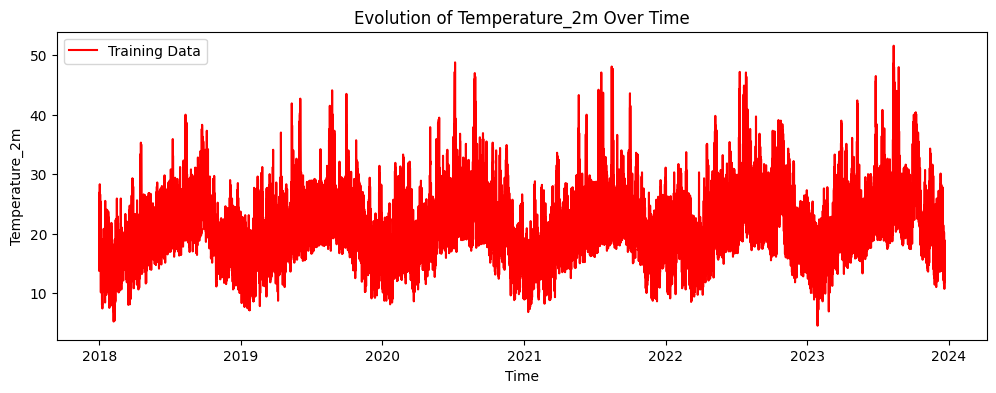

In [269]:
plt.figure(figsize=(12, 4))
plt.plot(df.select('time').rdd.flatMap(lambda x: x).collect(), df.select('temperature_2m').rdd.flatMap(lambda x: x)
                                                                 .collect(), color='red', 
                                                                  label='Training Data')
plt.xlabel('Time')
plt.ylabel('Temperature_2m')
plt.title('Evolution of Temperature_2m Over Time')
plt.legend()
plt.show()

> ## 2) - visualisation de l'évolution des températures pour l'année en cours

23/12/25 00:41:10 WARN TaskSetManager: Stage 3413 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:41:10 WARN TaskSetManager: Stage 3414 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:41:12 WARN TaskSetManager: Stage 3417 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:41:12 WARN TaskSetManager: Stage 3418 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


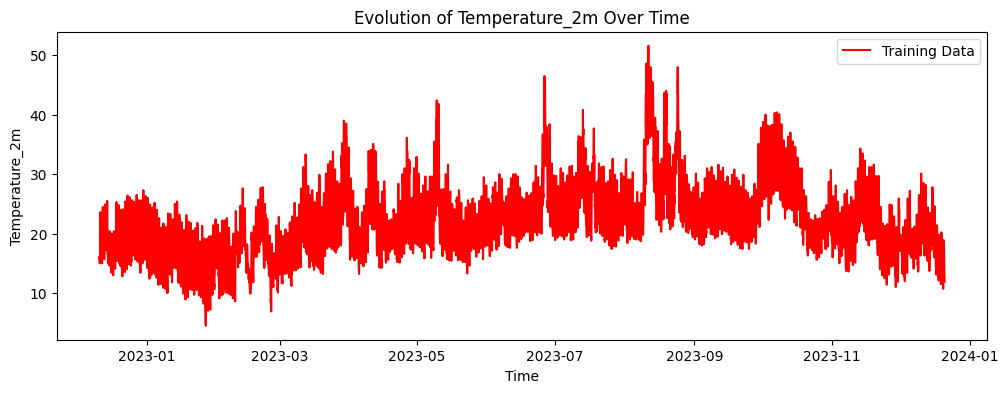

In [270]:
df = df.orderBy('time')
plt.figure(figsize=(12, 4))
plt.plot(df.select('time').rdd.flatMap(lambda x: x).collect()[-9000:], df.select('temperature_2m').rdd.flatMap(lambda x: x).collect()[-9000:], color='red', label='Training Data')
plt.xlabel('Time')
plt.ylabel('Temperature_2m')
plt.title('Evolution of Temperature_2m Over Time')
plt.legend()
plt.show()

# III) - feature Engineering : indexation chronologique
> ## 1) - maintenant, nous allons supprimer toutes les colonnes sauf « temps » et « température ».
>> - variable explicable : température.
>> - variable explicative : temps

In [271]:
# Select only the "time" and "assembled_features" columns
df = df.select("time", "temperature_2m")
df.show()

23/12/25 00:41:16 WARN TaskSetManager: Stage 3421 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


+-------------------+--------------+
|               time|temperature_2m|
+-------------------+--------------+
|2018-01-01 00:00:00|          16.4|
|2018-01-01 01:00:00|          15.4|
|2018-01-01 02:00:00|          14.8|
|2018-01-01 03:00:00|          14.5|
|2018-01-01 04:00:00|          13.7|
|2018-01-01 05:00:00|          13.9|
|2018-01-01 06:00:00|          15.9|
|2018-01-01 07:00:00|          15.5|
|2018-01-01 08:00:00|          14.1|
|2018-01-01 09:00:00|          16.6|
|2018-01-01 10:00:00|          19.8|
|2018-01-01 11:00:00|          24.0|
|2018-01-01 12:00:00|          25.6|
|2018-01-01 13:00:00|          26.9|
|2018-01-01 14:00:00|          26.0|
|2018-01-01 15:00:00|          25.2|
|2018-01-01 16:00:00|          26.1|
|2018-01-01 17:00:00|          23.8|
|2018-01-01 18:00:00|          18.1|
|2018-01-01 19:00:00|          17.0|
+-------------------+--------------+
only showing top 20 rows



> ## 2) - Si nous avons besoin de créer un modèle capable de prédire la température du futur, nous devons entraîner ce modèle sur des données ne contenant que des indices temporels. Ainsi, nous pourrons le former à cartographier la relation entre le temps et la variable cible. Pour ce faire, nous allons utiliser le script suivant.

In [272]:
data = df
df = (df
    .withColumn('hour', hour('time'))
    .withColumn('week', weekofyear('time'))
    .withColumn('month', month('time'))
    .withColumn('quarter', quarter('time'))
    .withColumn('day_of_week', dayofweek('time'))
    .withColumn('day_of_month', dayofmonth('time'))
    .withColumn('day_of_year', dayofyear('time'))
)
df.show()

23/12/25 00:41:21 WARN TaskSetManager: Stage 3422 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


+-------------------+--------------+----+----+-----+-------+-----------+------------+-----------+
|               time|temperature_2m|hour|week|month|quarter|day_of_week|day_of_month|day_of_year|
+-------------------+--------------+----+----+-----+-------+-----------+------------+-----------+
|2018-01-01 00:00:00|          16.4|   0|   1|    1|      1|          2|           1|          1|
|2018-01-01 01:00:00|          15.4|   1|   1|    1|      1|          2|           1|          1|
|2018-01-01 02:00:00|          14.8|   2|   1|    1|      1|          2|           1|          1|
|2018-01-01 03:00:00|          14.5|   3|   1|    1|      1|          2|           1|          1|
|2018-01-01 04:00:00|          13.7|   4|   1|    1|      1|          2|           1|          1|
|2018-01-01 05:00:00|          13.9|   5|   1|    1|      1|          2|           1|          1|
|2018-01-01 06:00:00|          15.9|   6|   1|    1|      1|          2|           1|          1|
|2018-01-01 07:00:00

> ## 3) -  la normalisation des  columns  :
>> #### La normalisation des données est cruciale pour garantir que toutes les caractéristiques contribuent équitablement aux modèles d'apprentissage automatique. Cela permet d'éviter que des variables avec des échelles différentes ne dominent l'apprentissage du modèle.







In [ ]:
data = df 

In [273]:
# Select columns to normalize
columns_to_normalize = ['hour', 'week', 'month', 'quarter', 'day_of_week', 'day_of_month', 'day_of_year']
for col_name in columns_to_normalize:
    min_value = df.agg({col_name: 'min'}).collect()[0][0]
    max_value = df.agg({col_name: 'max'}).collect()[0][0]
    normalized_column = col_name + '_normalized'
    df = df.withColumn(normalized_column, (col(col_name) - min_value) / (max_value - min_value))
    df = df.drop(col_name).withColumnRenamed(normalized_column, col_name)

23/12/25 00:41:27 WARN TaskSetManager: Stage 3423 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:41:27 WARN TaskSetManager: Stage 3426 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:41:27 WARN TaskSetManager: Stage 3429 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:41:27 WARN TaskSetManager: Stage 3432 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:41:28 WARN TaskSetManager: Stage 3435 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:41:28 WARN TaskSetManager: Stage 3438 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:41:28 WARN TaskSetManager: Stage 3441 contains a task of very large size (2979 KiB). The maximum recommended task size is 10

In [274]:
df.show()

23/12/25 00:41:34 WARN TaskSetManager: Stage 3465 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


+-------------------+--------------+--------------------+----+-----+-------+-------------------+------------+-----------+
|               time|temperature_2m|                hour|week|month|quarter|        day_of_week|day_of_month|day_of_year|
+-------------------+--------------+--------------------+----+-----+-------+-------------------+------------+-----------+
|2018-01-01 00:00:00|          16.4|                 0.0| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|
|2018-01-01 01:00:00|          15.4|0.043478260869565216| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|
|2018-01-01 02:00:00|          14.8| 0.08695652173913043| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|
|2018-01-01 03:00:00|          14.5| 0.13043478260869565| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|
|2018-01-01 04:00:00|          13.7| 0.17391304347826086| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|
|2018-01-01 05:00:00|   

In [ ]:
data = df

# IV) - Entraînement et évaluation des modèles.
> ### Dans cette section, nous allons essayer d'Entraîner plusieurs modèles sur nos données et choisir le modèle le plus performant

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
def display_model_performance(model, test_data):
    # Make predictions on the test data
    predictions = model.transform(test_data)

    # Evaluate the model
    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)

    # Convert the PySpark DataFrame to a Pandas DataFrame
    result_df = predictions.select("label", "prediction").toPandas()

    # Plot the graph
    plt.plot(result_df['label'], result_df['prediction'], 'bo')
    plt.xlabel('Temperature')
    plt.ylabel('Prediction')
    plt.suptitle("Model Performance RMSE: %f" % rmse)
    plt.show()
    

def evaluate_model(model, test_data):
    # Make predictions on the test data
    predictions = model.transform(test_data)
    forecast_bias = predictions.agg(F.avg(predictions['label'] - predictions['prediction'])).collect()[0][0]

    # Calculate R-squared (R2)
    evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')
    r2 = evaluator.evaluate(predictions)

    # Calculate Mean Absolute Scaled Error (MASE)
    mean_absolute_error = evaluator.evaluate(predictions, {evaluator.metricName: 'mae'})
    mase = mean_absolute_error / predictions.agg(F.mean('label')).collect()[0][0]

    # Calculate Symmetric Mean Absolute Percentage Error (SMAPE)
    smape_numerator = F.sum(F.abs(predictions['label'] - predictions['prediction']))
    smape_denominator = F.sum(F.abs(predictions['label']) + F.abs(predictions['prediction']))
    smape = F.when(smape_denominator == 0, 0).otherwise(200 * smape_numerator / smape_denominator)

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = F.avg(F.abs(predictions['label'] - predictions['prediction']) / F.abs(predictions['label']))

    # Calculate Root Mean Squared Error (RMSE)
    rmse = evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'})

    # Calculate Mean Squared Error (MSE)
    mse = evaluator.evaluate(predictions, {evaluator.metricName: 'mse'})

    # Calculate Mean Absolute Error (MAE)
    mae = evaluator.evaluate(predictions, {evaluator.metricName: 'mae'})

    # Print the metrics
    print(f"Forecast Bias: {forecast_bias}")
    print(f"R-squared (R2): {r2}")
    print(f"Mean Absolute Scaled Error (MASE): {mase}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    return [ forecast_bias , r2 , mase , rmse , mse , mae ]
#  [ 'Forecast Bias' , 'R-squared (R2)' , 'Mean Absolute Scaled Error (MASE)' , 'Root Mean Squared Error (RMSE)','Mean Squared Error (MSE)' , 'Mean Absolute Error (MAE)']


In [ ]:
data = df 
df = df.drop('time')

In [275]:
from pyspark.ml.feature import VectorAssembler
feature_list = []
df = df.withColumnRenamed("temperature_2m", "label")
for col in df.columns:
    if col == 'temperature_2m':
        continue
    else:
        feature_list.append(col)
assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

In [276]:
# Sort the data based on 'time'
df = df.orderBy('time')

> ## 1) - Construction et entrainement du modèle Random Forest Regressor.
>> ### - Forces:
>> ### + Méthode d'ensemble qui réduit le surajustement par rapport aux arbres de décision individuels.
>> ### + Robuste et gère bien les valeurs aberrantes.
>> ### - Désavantages:
>> ### + Plus complexe qu’un seul arbre de décision.

>>> ### a) Construction du model 

In [277]:
rf = RandomForestRegressor(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[assembler, rf])

In [278]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

In [279]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

In [ ]:
df = data.withColumnRenamed('temperature_2m', 'label')
df = df.withColumn("time", to_timestamp("time"))
trainingData = df.filter(col('time') < '2023-01-01 12:00:00').drop('time')
testData = df.filter(col('time') >= '2023-01-01 12:00:00').drop('time')
trainingData.show(3)

In [ ]:
trainingData = trainingData.withColumn("label", trainingData["label"].cast(DoubleType()))
testData = testData.withColumn("label", testData["label"].cast(DoubleType()))

>>> ### b) Entrainement du model 

In [ ]:
cvModel = crossval.fit(trainingData)

>>> ### c) Prediction du model 

In [ ]:
predictions = DecisionTreeR_model.transform(testData)

>>> ### d) évaluation des performances du modèle

In [252]:
models_performance = []
models_performance.append(['RandomForestRegressor']+evaluate_model(cvModel, testData))

23/12/25 00:33:56 WARN TaskSetManager: Stage 3274 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:33:57 WARN TaskSetManager: Stage 3277 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:33:58 WARN TaskSetManager: Stage 3278 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:33:58 WARN TaskSetManager: Stage 3279 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:33:58 WARN TaskSetManager: Stage 3282 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:33:59 WARN TaskSetManager: Stage 3283 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:34:00 WARN TaskSetManager: Stage 3284 contains a task of very large size (2979 KiB). The maximum recommended task size is 10

Forecast Bias: 0.14757012699053085
R-squared (R2): 0.981833876785637
Mean Absolute Scaled Error (MASE): 0.0173103603865755
Root Mean Squared Error (RMSE): 0.8474661274192703
Mean Squared Error (MSE): 0.7181988371230149
Mean Absolute Error (MAE): 0.3809325986470272


>>> ### d) Analyse de l'importance des variables explicatives pour la prédiction

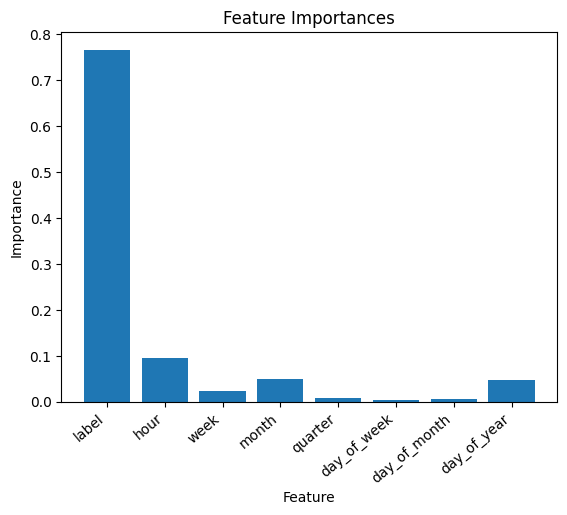

In [253]:
display_feature_importances(cvModel)

>>> ### e) - analyse la cohérence entre la température prévue et la température réelle

23/12/25 00:34:01 WARN TaskSetManager: Stage 3285 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:34:01 WARN TaskSetManager: Stage 3286 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


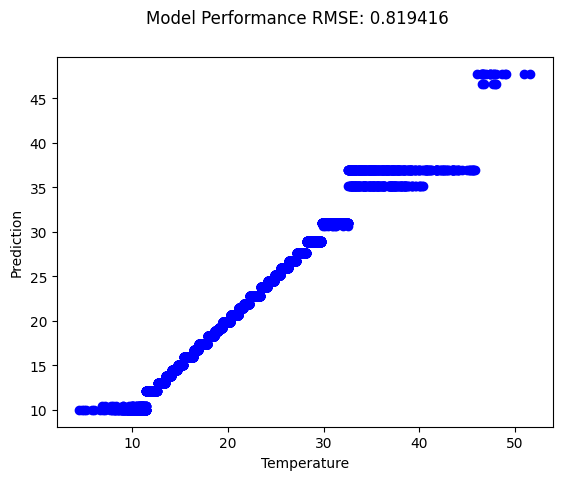

In [254]:
display_model_performance(model, testData)

        Feature  Importance
0         label    0.766365
1          hour    0.095906
3         month    0.050069
7   day_of_year    0.047820
2          week    0.023061
4       quarter    0.007743
6  day_of_month    0.006069
5   day_of_week    0.002966


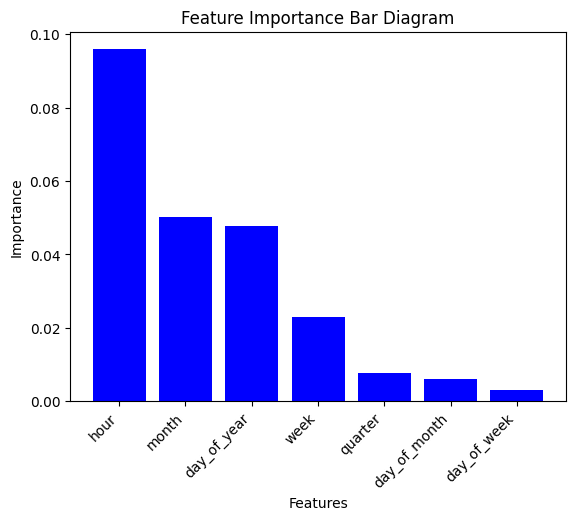

In [255]:
# Extract feature importances from the trained RandomForestRegressor model
feature_importances = cvModel.bestModel.stages[-1].featureImportances
feature_importance_df = pd.DataFrame({
    'Feature': assembler.getInputCols(),
    'Importance': feature_importances.toArray()
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

importance = list(feature_importance_df.Importance )[1:]
Feature = list(feature_importance_df.Feature )[1:]

plt.bar(Feature, importance, color='blue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Bar Diagram')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# Save the model to a folder
model.save("models/random_forest_model")

In [ ]:
# Load the model from the folder
loaded_model = PipelineModel.load("models/random_forest_model")

# Make predictions on new data
new_data = ...  # Provide new data in a DataFrame format
predictions = loaded_model.transform(new_data)

# Show the predictions
predictions.show()

> ## Gradient-Boosted Trees 

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor


>>> ### a) Construction et Entrainement du model du model 

In [ ]:

# Create a GBT model
gbt = GBTRegressor(featuresCol='features', labelCol='label', maxIter=10, seed=42)
# Create a pipeline with the assembler and the GBT model
pipeline = Pipeline(stages=[assembler, gbt])
# Fit the pipeline on the training data
GBTRegressor_model = pipeline.fit(trainingData)

>>> ### b) évaluation des performances du modèle

In [256]:
models_performance.append(['GBTRegressor_model']+evaluate_model(GBTRegressor_model, testData))

23/12/25 00:34:54 WARN TaskSetManager: Stage 3287 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:34:54 WARN TaskSetManager: Stage 3290 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:34:54 WARN TaskSetManager: Stage 3291 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:34:55 WARN TaskSetManager: Stage 3292 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:34:55 WARN TaskSetManager: Stage 3295 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:34:56 WARN TaskSetManager: Stage 3296 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:34:56 WARN TaskSetManager: Stage 3297 contains a task of very large size (2979 KiB). The maximum recommended task size is 10

Forecast Bias: 0.06870655863866651
R-squared (R2): 0.9770798456012372
Mean Absolute Scaled Error (MASE): 0.016928571179081142
Root Mean Squared Error (RMSE): 0.951918989452185
Mean Squared Error (MSE): 0.9061497624796692
Mean Absolute Error (MAE): 0.37253092752647654


>>> ### c) Analyse de l'importance des variables explicatives pour la prédiction

        Feature  Importance
0         label    0.983100
1          hour    0.006212
5   day_of_week    0.003230
7   day_of_year    0.003219
2          week    0.002188
6  day_of_month    0.001233
3         month    0.000819
4       quarter    0.000000


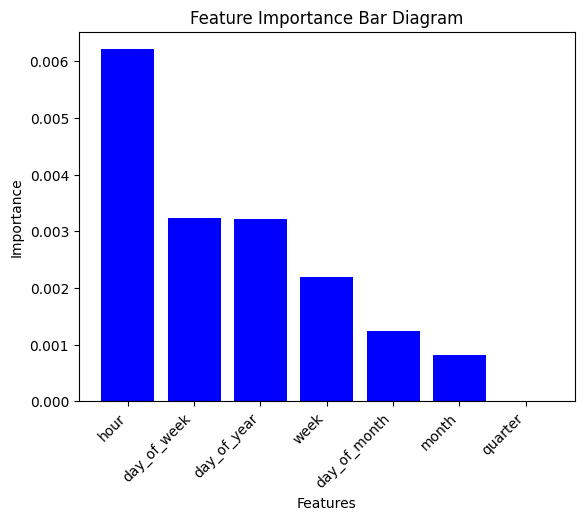

In [258]:
# Extract feature importances from the trained GBT model
feature_importances = GBTRegressor_model.stages[-1].featureImportances

# Create a DataFrame to display feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': assembler.getInputCols(),
    'Importance': feature_importances.toArray()
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

importance = list(feature_importance_df.Importance )[1:]
Feature = list(feature_importance_df.Feature )[1:]

plt.bar(Feature, importance, color='blue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Bar Diagram')
plt.xticks(rotation=45, ha='right')
plt.show()

>>> ### c) - analyse la cohérence entre la température prévue et la température réelle

23/12/25 00:36:08 WARN TaskSetManager: Stage 3298 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:36:08 WARN TaskSetManager: Stage 3299 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


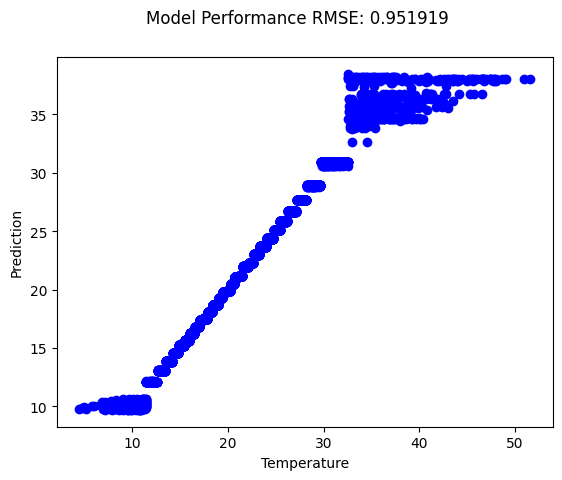

In [259]:
display_model_performance(GBTRegressor_model, testData)

> ## Support Vector Machines (SVM)

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

>>> ### a) Construction du model 

In [ ]:
from pyspark.ml.feature import VectorAssembler

feature_list = []
df = df.withColumnRenamed("temperature_2m", "label")
for col in df.columns:
    if col == 'temperature_2m':
        continue
    else:
        feature_list.append(col)
        
assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

trainingData = trainingData.withColumn("label", trainingData["label"].cast(DoubleType()))
testData = testData.withColumn("label", testData["label"].cast(DoubleType()))

dt = DecisionTreeRegressor(featuresCol='features', labelCol='label')
pipeline = Pipeline(stages=[assembler, dt])

DecisionTreeR_model = pipeline.fit(trainingData)

>>> ### b) évaluation des performances du modèle

In [260]:
models_performance.append(['DecisionTreeR_model']+evaluate_model(DecisionTreeR_model,testData))

23/12/25 00:36:42 WARN TaskSetManager: Stage 3300 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:36:43 WARN TaskSetManager: Stage 3303 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:36:43 WARN TaskSetManager: Stage 3304 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:36:43 WARN TaskSetManager: Stage 3305 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:36:44 WARN TaskSetManager: Stage 3308 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:36:44 WARN TaskSetManager: Stage 3309 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:36:45 WARN TaskSetManager: Stage 3310 contains a task of very large size (2979 KiB). The maximum recommended task size is 10

Forecast Bias: 0.020231941210291305
R-squared (R2): 0.9830165123597727
Mean Absolute Scaled Error (MASE): 0.01722592138559277
Root Mean Squared Error (RMSE): 0.8194164170022697
Mean Squared Error (MSE): 0.6714432644528376
Mean Absolute Error (MAE): 0.3790744300501183


>>> ### e) - analyse la cohérence entre la température prévue et la température réelle

23/12/25 00:37:06 WARN TaskSetManager: Stage 3311 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.
23/12/25 00:37:06 WARN TaskSetManager: Stage 3312 contains a task of very large size (2979 KiB). The maximum recommended task size is 1000 KiB.


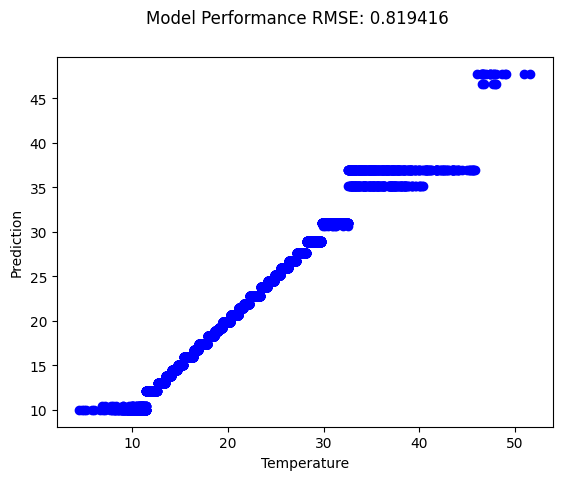

In [261]:
display_model_performance(DecisionTreeR_model, testData)

>>> ### c) Analyse de l'importance des variables explicatives pour la prédiction

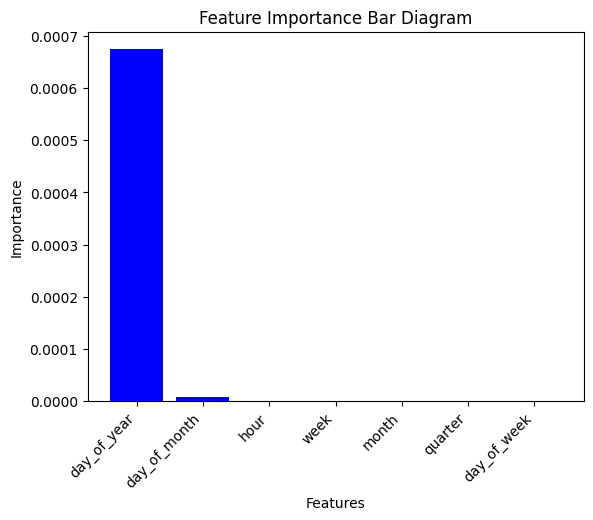

In [262]:
# Extract feature importances from the trained Decision Tree model
feature_importances_dt = DecisionTreeR_model.stages[-1].featureImportances
feature_importance_dt_df = pd.DataFrame({
    'Feature': assembler.getInputCols(),
    'Importance': feature_importances_dt.toArray()
})
feature_importance_dt_df = feature_importance_dt_df.sort_values(by='Importance', ascending=False)
importance = list(feature_importance_dt_df.Importance )[1:]
Feature = list(feature_importance_dt_df.Feature )[1:]

plt.bar(Feature, importance, color='blue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Bar Diagram')
plt.xticks(rotation=45, ha='right')
plt.show()

In [263]:
cols = [ 'model' ,'Forecast Bias' , 'R-squared (R2)' , 'Mean Absolute Scaled Error (MASE)' , 'Root Mean Squared Error (RMSE)','Mean Squared Error (MSE)' , 'Mean Absolute Error (MAE)']
pd.DataFrame(models_performance , columns = cols )

,model,Forecast Bias,R-squared (R2),Mean Absolute Scaled Error (MASE),Root Mean Squared Error (RMSE),Mean Squared Error (MSE),Mean Absolute Error (MAE)
0,RandomForestRegressor,0.147570,0.981834,0.017310,0.847466,0.718199,0.380933
1,GBTRegressor_model,0.068707,0.977080,0.016929,0.951919,0.906150,0.372531
2,DecisionTreeR_model,0.020232,0.983017,0.017226,0.819416,0.671443,0.379074
